# 电影评论情感分类     

本实验将中文电影评论分类为“positive”、“negative”。

首先导入必要的库：

In [1]:
import gensim
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import time
from collections import Counter
from torch.utils.data import TensorDataset,DataLoader
from torch.optim.lr_scheduler import *

# 加载数据集

数据集包括：
1. 训练集。包含2W条左右中文电影评论，其中正负向评论各1W条左右。
2. 验证集。包含6K条左右中文电影评论，其中正负向评论各3K条左右。
3. 测试集。包含360条左右中文电影评论，其中正负向评论各180条左右。
4. 预训练词向量。中文维基百科词向量word2vec。

(1) 构建词汇表并存储，形如{word: id}：

In [2]:
def build_word2id(file, save_to_path=None):
    """
    :param file: word2id保存地址
    :param save_to_path: 保存训练语料库中的词组对应的word2vec到本地
    :return: None
    """
    word2id = {'_PAD_': 0}
    path = ['./Dataset/train.txt', './Dataset/validation.txt']
    
    for _path in path:
        with open(_path, encoding='utf-8') as f:
            for line in f.readlines():
                sp = line.strip().split()
                for word in sp[1:]:
                    if word not in word2id.keys():
                        word2id[word] = len(word2id)
    if save_to_path:                    
        with open(file, 'w', encoding='utf-8') as f:
            for w in word2id:
                f.write(w+'\t')
                f.write(str(word2id[w]))
                f.write('\n')
    
    return word2id

(2)基于预训练的word2vec构建训练语料中所含词语的word2vec：

In [3]:
def build_word2vec(fname, word2id, save_to_path=None):
    """
    :param fname: 预训练的word2vec.
    :param word2id: 语料文本中包含的词汇集.
    :param save_to_path: 保存训练语料库中的词组对应的word2vec到本地
    :return: 语料文本中词汇集对应的word2vec向量{id: word2vec}.
    """
    n_words = max(word2id.values()) + 1
    model = gensim.models.KeyedVectors.load_word2vec_format(fname, binary=True)
    word_vecs = np.array(np.random.uniform(-1., 1., [n_words, model.vector_size]))
    for word in word2id.keys():
        try:
            word_vecs[word2id[word]] = model[word]
        except KeyError:
            pass
    if save_to_path:
        with open(save_to_path, 'w', encoding='utf-8') as f:
            for vec in word_vecs:
                vec = [str(w) for w in vec]
                f.write(' '.join(vec))
                f.write('\n')
    return word_vecs

(3)分类类别以及id对应词典{pos:0, neg:1}：

In [4]:
def cat_to_id(classes=None):
    """
    :param classes: 分类标签；默认为0:pos, 1:neg
    :return: {分类标签：id}
    """
    if not classes:
        classes = ['0', '1']
    cat2id = {cat: idx for (idx, cat) in enumerate(classes)}
    return classes, cat2id

(4)加载语料库：train/dev/test：

In [5]:
def load_corpus(path, word2id, max_sen_len=50):
    """
    :param path: 样本语料库的文件
    :return: 文本内容contents，以及分类标签labels(onehot形式)
    """
    _, cat2id = cat_to_id()
    contents, labels = [], []
    with open(path, encoding='utf-8') as f:
        for line in f.readlines():
            sp = line.strip().split()
            label = sp[0]
            content = [word2id.get(w, 0) for w in sp[1:]]
            content = content[:max_sen_len]
            if len(content) < max_sen_len:
                content += [word2id['_PAD_']] * (max_sen_len - len(content))
            labels.append(label)
            contents.append(content)
    counter = Counter(labels)
    print('Total sample num：%d' % (len(labels)))
    print('class num：')
    for w in counter:
        print(w, counter[w])

    contents = np.asarray(contents)
    labels = np.array([cat2id[l] for l in labels])

    return contents, labels

In [6]:
word2id = build_word2id('./Dataset/word2id.txt')
# print(word2id)
word2vec = build_word2vec('./Dataset/wiki_word2vec_50.bin', word2id)
assert word2vec.shape == (58954, 50)
# print(word2vec)
print('train set: ')
train_contents, train_labels = load_corpus('./Dataset/train.txt', word2id, max_sen_len=50)
print('\nvalidation set: ')
val_contents, val_labels = load_corpus('./Dataset/validation.txt', word2id, max_sen_len=50)
print('\ntest set: ')
test_contents, test_labels = load_corpus('./Dataset/test.txt', word2id, max_sen_len=50)

train set: 
Total sample num：19998
class num：
1 9999
0 9999

validation set: 
Total sample num：5629
class num：
1 2812
0 2817

test set: 
Total sample num：369
class num：
1 187
0 182


经过数据预处理，数据的格式如下：
- x: [1434, 5454, 2323, ..., 0, 0, 0]
- y: [1]

x为构成一条语句的单词所对应的id。 y为类别: pos：0, neg：1。

# 构建模型

构建Text-CNN模型，模型结构如下图所示：

![](https://pic.downk.cc/item/5e9bc837c2a9a83be5a96d95.jpg)

模型包括词嵌入层、卷积层、池化层和全连接层。

(1)配置模型相关参数，在COINFIG类中完成：

In [7]:
class CONFIG():
    update_w2v = True           # 是否在训练中更新w2v
    vocab_size = 58954          # 词汇量，与word2id中的词汇量一致
    n_class = 2                 # 分类数：分别为pos和neg
    embedding_dim = 50          # 词向量维度
    drop_keep_prob = 0.5        # dropout层，参数keep的比例
    kernel_num = 64            # 卷积层filter的数量
    kernel_size = [3,4,5]       # 卷积核的尺寸
    pretrained_embed = word2vec # 预训练的词嵌入模型

(2)构建Text-CNN模型：

In [8]:
class TextCNN(nn.Module):
    def __init__(self, config):
        super(TextCNN, self).__init__()
        update_w2v = config.update_w2v
        vocab_size = config.vocab_size
        n_class = config.n_class
        embedding_dim = config.embedding_dim
        kernel_num = config.kernel_num
        kernel_size = config.kernel_size
        drop_keep_prob = config.drop_keep_prob
        pretrained_embed = config.pretrained_embed
        
        # 使用预训练的词向量
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding.weight.data.copy_(torch.from_numpy(pretrained_embed))
        self.embedding.weight.requires_grad = update_w2v
        # 卷积层
        self.conv1 = nn.Conv2d(1, kernel_num, (kernel_size[0], embedding_dim))
        self.conv2 = nn.Conv2d(1, kernel_num, (kernel_size[1], embedding_dim))
        self.conv3 = nn.Conv2d(1, kernel_num, (kernel_size[2], embedding_dim))
        # Dropout
        self.dropout = nn.Dropout(drop_keep_prob)
        # 全连接层
        self.fc = nn.Linear(len(kernel_size) * kernel_num, n_class)

    @staticmethod
    def conv_and_pool(x, conv):
        # x: (batch, 1, sentence_length,  )
        x = conv(x)
        # x: (batch, kernel_num, H_out, 1)
        x = F.relu(x.squeeze(3))
        # x: (batch, kernel_num, H_out)
        x = F.max_pool1d(x, x.size(2)).squeeze(2)
        #  (batch, kernel_num)
        return x
        
    def forward(self, x):
        x = x.to(torch.int64)
        x = self.embedding(x)
        x = x.unsqueeze(1)
        x1 = self.conv_and_pool(x, self.conv1)  # (batch, kernel_num)
        x2 = self.conv_and_pool(x, self.conv2)  # (batch, kernel_num)
        x3 = self.conv_and_pool(x, self.conv3)  # (batch, kernel_num)
        x = torch.cat((x1, x2, x3), 1)  # (batch, 3 * kernel_num)
        x = self.dropout(x)
        x = self.fc(x)
        x = F.log_softmax(x, dim=1)
        return x

# 训练模型

(1)设置超参数:

In [9]:
config = CONFIG()          # 配置模型参数
learning_rate = 0.001      # 学习率     
BATCH_SIZE = 50            # 训练批量
EPOCHS = 10                 # 训练轮数
model_path = None          # 预训练模型路径
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

(2)加载训练数据：

In [10]:
# 加载训练用的数据
train_dataset = TensorDataset(torch.from_numpy(train_contents).type(torch.float), 
                              torch.from_numpy(train_labels).type(torch.long))
train_dataloader = DataLoader(dataset = train_dataset, batch_size = BATCH_SIZE, 
                              shuffle = True, num_workers = 2)

val_dataset = TensorDataset(torch.from_numpy(val_contents).type(torch.float), 
                              torch.from_numpy(val_labels).type(torch.long))
val_dataloader = DataLoader(dataset = train_dataset, batch_size = BATCH_SIZE, 
                              shuffle = True, num_workers = 2)

(3)训练：

In [11]:
# 配置模型，是否继续上一次的训练
model = TextCNN(config)
if model_path:
    model.load_state_dict(torch.load(model_path))
model.to(DEVICE)
    
# 设置优化器
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

# 设置损失函数
criterion = nn.CrossEntropyLoss()
scheduler = StepLR(optimizer, step_size=5)

In [12]:
def train(dataloader,epoch):
    # 定义训练过程
    train_loss,train_acc = 0.0,0.0
    count, correct = 0,0
    for batch_idx, (x, y) in enumerate(dataloader):
        x, y = x.to(DEVICE), y.to(DEVICE)
        optimizer.zero_grad()
        output = model(x)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        correct += (output.argmax(1) == batch_y).float().sum().item()
        count += len(x)
            
        if (batch_idx+1) % 100 == 0:
            print('train epoch: {} [{}/{} ({:.0f}%)]\tloss: {:.6f}'.format(
                epoch, batch_idx * len(x), len(dataloader.dataset),
                100. * batch_idx / len(dataloader), loss.item()))
                
    train_loss *= BATCH_SIZE
    train_loss /= len(dataloader.dataset)
    train_acc = correct/count
    print('\ntrain epoch: {}\taverage loss: {:.6f}\taccuracy:{:.4f}%\n'.format(epoch,train_loss,100.*train_acc))
    scheduler.step()
    
    return train_loss,train_acc

In [13]:
def validation(dataloader,epoch):
    # 验证过程
    val_loss,val_acc = 0.0,0.0
    count, correct = 0,0
    for _, (x, y) in enumerate(dataloader):
        x, y = x.to(DEVICE), y.to(DEVICE)
        output = model(x)
        loss = criterion(output, y)
        val_loss += loss.item()
        correct += (output.argmax(1) == y).float().sum().item()
        count += len(x)
    
    val_loss *= BATCH_SIZE
    val_loss /= len(dataloader.dataset)
    val_acc = correct/count
    # 打印准确率
    print('validation:train epoch: {}\taverage loss: {:.6f}\t accuracy:{:.2f}%\n'.format(epoch,val_loss,100*val_acc))
    
    return val_loss,val_acc

In [14]:
train_losses = []
train_acces = []
val_losses = []
val_acces = []

for epoch in range(1,EPOCHS+1):
    tr_loss,tr_acc = train(train_dataloader,epoch)
    val_loss,val_acc = validation(val_dataloader,epoch)
    train_losses.append(tr_loss)
    train_acces.append(tr_acc)
    val_losses.append(val_loss)
    val_acces.append(val_acc)
    
model_pth = 'model_' + str(time.time()) + '.pth'
torch.save(model.state_dict(), model_pth)

train epoch: 1 [4950/19998 (25%)]	loss: 0.571771
train epoch: 1 [9950/19998 (50%)]	loss: 0.587048
train epoch: 1 [14950/19998 (75%)]	loss: 0.367255
train epoch: 1 [19152/19998 (100%)]	loss: 0.536445

train epoch: 1	average loss: 0.536496	accuracy:72.1222%

validation:train epoch: 1	average loss: 0.413163	 accuracy:81.43%

train epoch: 2 [4950/19998 (25%)]	loss: 0.291574
train epoch: 2 [9950/19998 (50%)]	loss: 0.299588
train epoch: 2 [14950/19998 (75%)]	loss: 0.246201
train epoch: 2 [19152/19998 (100%)]	loss: 0.322882

train epoch: 2	average loss: 0.367031	accuracy:83.8284%

validation:train epoch: 2	average loss: 0.269979	 accuracy:89.45%

train epoch: 3 [4950/19998 (25%)]	loss: 0.149702
train epoch: 3 [9950/19998 (50%)]	loss: 0.268242
train epoch: 3 [14950/19998 (75%)]	loss: 0.183366
train epoch: 3 [19152/19998 (100%)]	loss: 0.171744

train epoch: 3	average loss: 0.260188	accuracy:89.6090%

validation:train epoch: 3	average loss: 0.171648	 accuracy:94.22%

train epoch: 4 [4950/19998 (

(4)可视化训练过程中的loss和accuracy

In [15]:
def draw_plot(data,label,x,y):
    plt.plot(data,label=label)
    plt.xlabel(x, fontsize=14)
    plt.ylabel(y, fontsize=14)
    plt.legend()

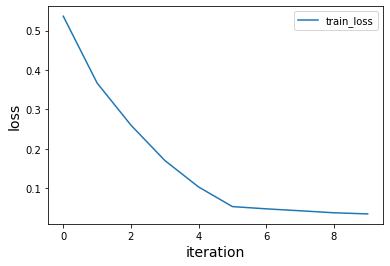

In [16]:
draw_plot(train_losses,"train_loss","iteration","loss")

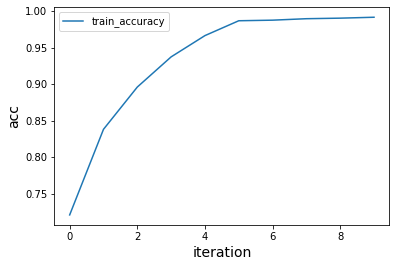

In [17]:
draw_plot(train_acces,"train_accuracy","iteration","acc")

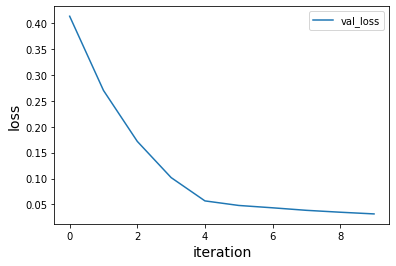

In [18]:
draw_plot(val_losses,"val_loss","iteration","loss")

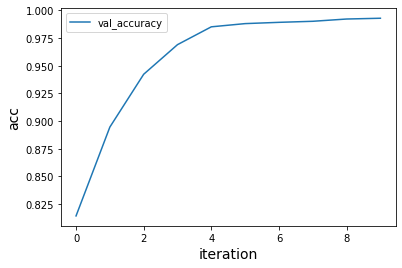

In [19]:
draw_plot(val_acces,"val_accuracy","iteration","acc")

# 测试模型

测试模型在测试集的准确率：

In [20]:
# 设置超参数
model_path = model_pth    # 模型路径
# 加载测试集
test_dataset = TensorDataset(torch.from_numpy(test_contents).type(torch.float), 
                            torch.from_numpy(test_labels).type(torch.long))
test_dataloader = DataLoader(dataset = test_dataset, batch_size = BATCH_SIZE, 
                            shuffle = False, num_workers = 2)
# 读取模型
model = TextCNN(config)
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [21]:
def test(dataloader):
    model.eval()
    model.to(DEVICE)
    
    # 测试过程
    count, correct = 0, 0
    for _, (x, y) in enumerate(dataloader):
        x, y = x.to(DEVICE), y.to(DEVICE)
        output = model(x)
        correct += (output.argmax(1) == y).float().sum().item()
        count += len(x)
    
    # 打印准确率
    print('test accuracy:{:.2f}%.'.format(100*correct/count))

In [22]:
test(test_dataloader)

test accuracy:82.66%.


In [23]:
print(model)

TextCNN(
  (embedding): Embedding(58954, 50)
  (conv1): Conv2d(1, 64, kernel_size=(3, 50), stride=(1, 1))
  (conv2): Conv2d(1, 64, kernel_size=(4, 50), stride=(1, 1))
  (conv3): Conv2d(1, 64, kernel_size=(5, 50), stride=(1, 1))
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=192, out_features=2, bias=True)
)
